In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings

from pycaret import Train, TrainControl, expand_grid
from pycaret.performance_metrics.metrics import twoClassSummary, AUC
from pycaret.ml_helpers.feature_selection import findCorrelation, nearZeroVariance

from pycaret.cls_models.linear_models import GLM_L1
from pycaret.cls_models.trees_rules import RF_Cls, XGB_Cls
from pycaret.cls_models.nonlinear_models import NNet_Cls, KNN_Cls

# some custom plotting functions that will go into next release of pycaret
from plot_funcs import kde_plot, hist_plot, cat_plot, pairwise_plot

%matplotlib inline
warnings.filterwarnings('ignore')

/home/phil/anaconda3/envs/pycaret-env/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load in churn dataset

Taken from the R C5.0 package

In [112]:
# read data
path = '~/Python/churn/'
churnTrain = pd.read_csv(path+"churnTrain.csv", sep=",")
churnTest = pd.read_csv(path+"churnTest.csv", sep=",")

In [3]:
inputCols = churnTrain.columns.values
inputCols = inputCols[inputCols !="churn"]

inputTrain = churnTrain[inputCols]
outcomeTrain = churnTrain["churn"]
inputTest = churnTest[inputCols]
outcomeTest = churnTest["churn"]

In [4]:
# lets convert outcome to numeric
outcomeTrain = outcomeTrain.apply(lambda x: 0 if x == "no" else 1)
outcomeTest = outcomeTest.apply(lambda x: 0 if x == "no" else 1)

In [5]:
# somewhat imbalanced classes
print()
print("number of training samples: {}".format(outcomeTrain.count()))
print("{:.2f}% churn".format(outcomeTrain.sum() / outcomeTrain.count() * 100))


number of training samples: 3333
14.49% churn


## Let's examine categorical and numerical features seperately

In [6]:
# seperate numeric and categorical inputs
numColsTrain = inputTrain.loc[:, inputTrain.dtypes != np.object]
catColsTrain = inputTrain.loc[:, inputTrain.dtypes == np.object]

numColsTest = inputTest.loc[:, inputTest.dtypes != np.object]
catColsTest = inputTest.loc[:, inputTest.dtypes == np.object]

### Numeric

In [7]:
numColNames = set(numColsTrain.columns.values)

In [8]:
numVar = list(numColNames)
churnLoc = outcomeTrain[outcomeTrain==1].index.values
nochurnLoc = outcomeTrain[outcomeTrain==0].index.values

In [9]:
numColNames

{'account_length',
 'number_customer_service_calls',
 'number_vmail_messages',
 'total_day_calls',
 'total_day_charge',
 'total_day_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_eve_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'total_intl_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_night_minutes'}

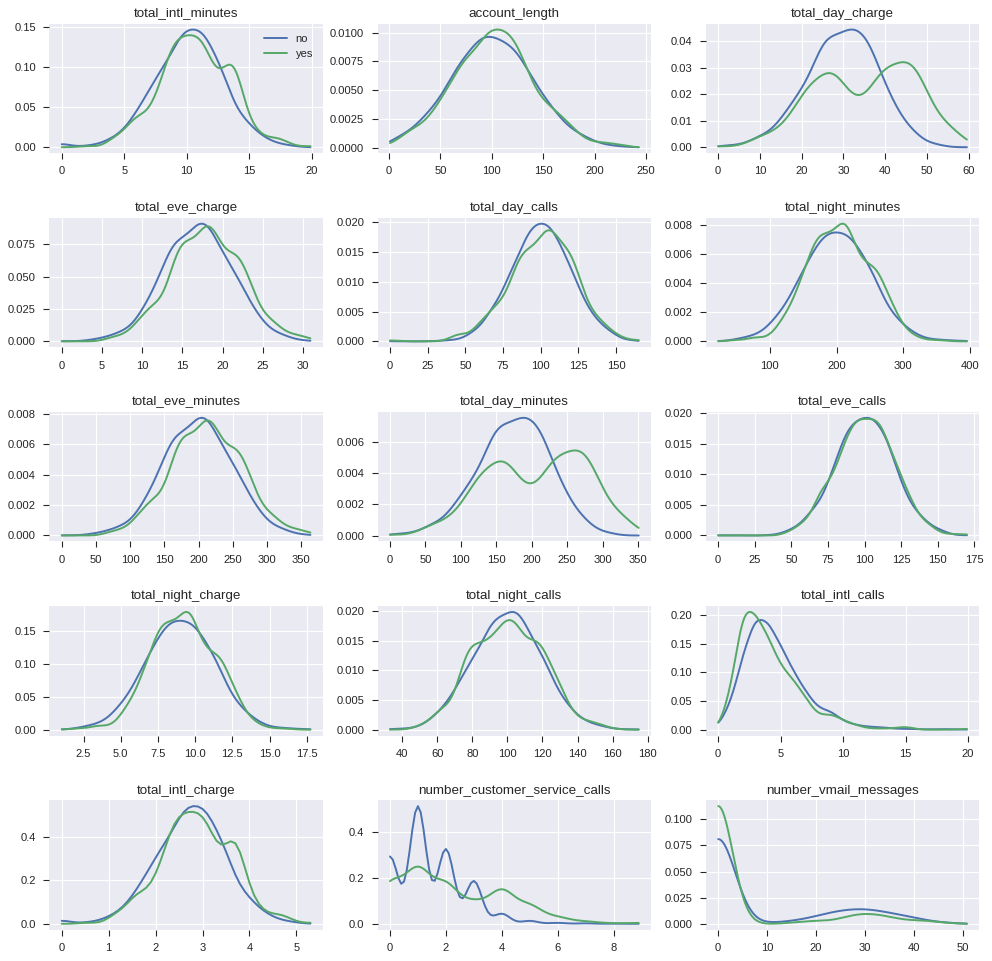

In [10]:
# I like kde plots for numeric: even when imbalanced classes, they are normalised
# to one- distributions are comparable
kde_plot(churnTrain.loc[:, list(numColNames) + ['churn']],
         outcome_col = 'churn',
         n_col = 3,
         plot_legend = True)

#kde_plot(inputTrain.loc[:, numColNames])

In [11]:
# could look at histogram instead of kde plot. normalised by default.
# hist_plot(churnTrain.loc[:, list(numColNames) + ['churn']],
#          outcome_col = 'churn',
#          n_col = 3,
#          plot_legend = True)

# hist_plot(churnTrain.loc[:, list(numColNames)],
#          n_col = 3)

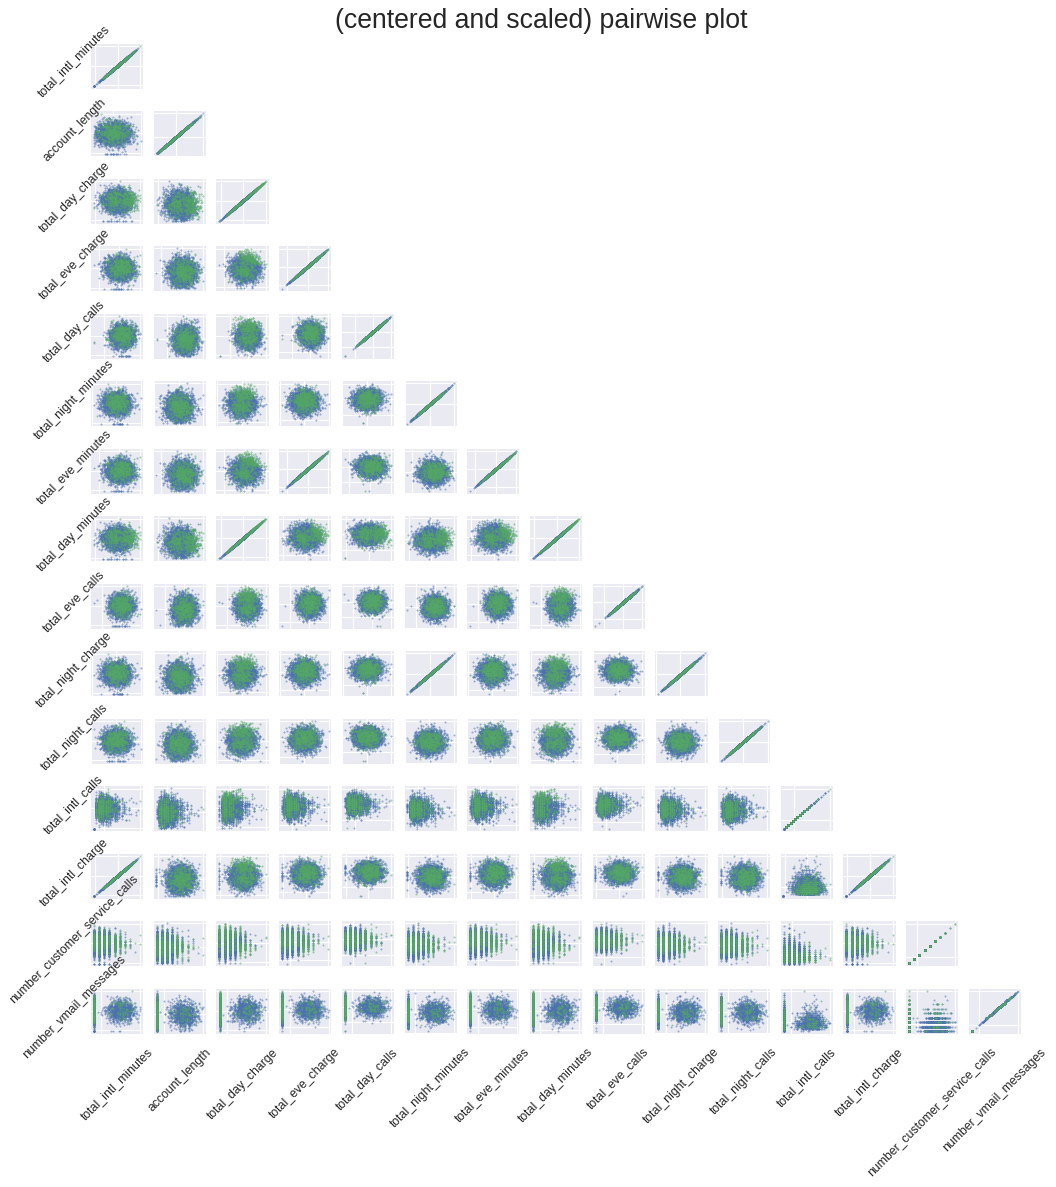

In [12]:
# investigate correlations between predictors
pairwise_plot(churnTrain.loc[:, list(numColNames) + ['churn']],
         outcome_col = 'churn',
         plot_legend = True)

# pairwise_plot(churnTrain.loc[:, list(numColNames)])

In [13]:
# lets home in on those highly correlated features
# as expected, charges are correlated with number of minutes
# pycaret has a findCorrelation helper function
findCorrelation(numColsTrain, threshold = 0.9)

['total_intl_charge',
 'total_night_minutes',
 'total_day_charge',
 'total_eve_charge']

In [14]:
# these columns are almost 100% correlated! utterly redundant
findCorrelation(numColsTrain, threshold = 0.99)

['total_intl_charge',
 'total_night_minutes',
 'total_day_charge',
 'total_eve_charge']

In [15]:
corrCols = set(findCorrelation(numColsTrain, threshold = 0.9))
# build up a full and reduced set of features
keepNumColsFull = numColNames - corrCols
keepNumColsReduced = numColNames - corrCols

In [16]:
# check for zero variance predictors
# number_vmail_messages has been flagged as near zero variance
nearZeroVariance(numColsTrain.loc[:, keepNumColsReduced])

([], ['number_vmail_messages'])

In [17]:
# leave number_vmail_messages in for models that 
# can perform intrinsic feature selection (e.g random forest)
# remove for others
keepNumColsReduced -= set('number_vmail_messages')

## Categorical

Start by visualising

In [18]:
catColNames = set(catColsTrain.columns.values)
catVar = list(catColNames)

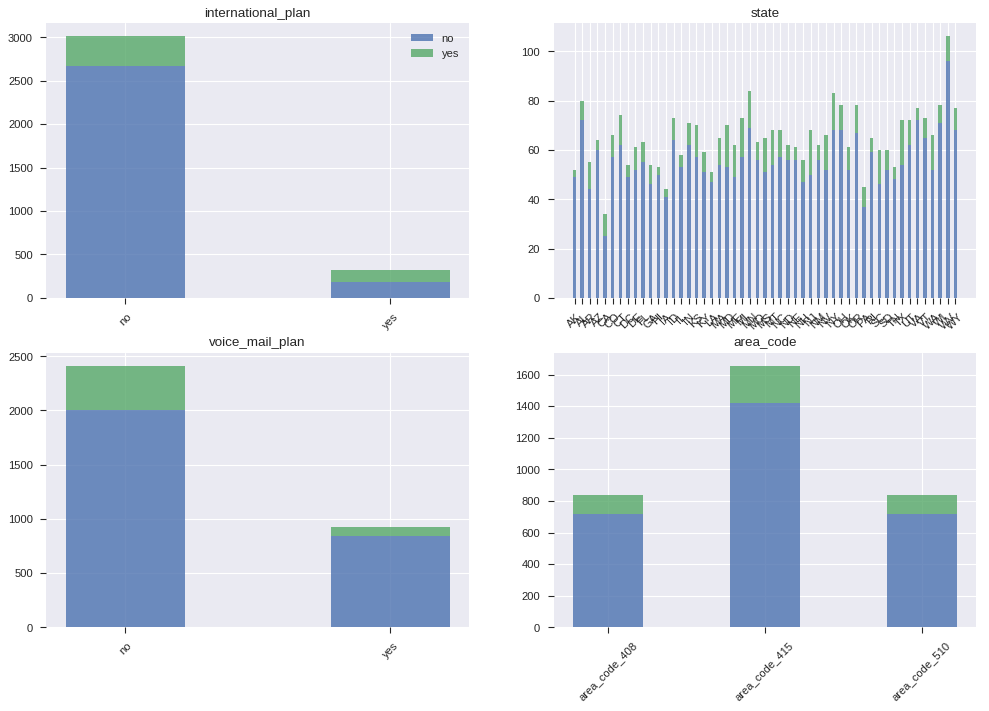

In [19]:
cat_plot(churnTrain.loc[:, list(catVar) + ['churn']],
         outcome_col = 'churn',
         n_col = 2,
         plot_legend = True,
         f_size = (15,10))

We get an intuitiion that the state is fairly useless as a predictive variable- so few customers come from each state, which will leas to a low variance predictive input. 

We also notice that approx 50% of customers with voicemail plans churn- this is quite informative!

### use pd.get_dummmies to one-hot encode

In [20]:
catColsTrain = pd.get_dummies(catColsTrain)
catColsTest = pd.get_dummies(catColsTest)

In [21]:
catColNames = set(catColsTrain.columns.values)

In [22]:
# all the states are, unsuprisingly, low variance predictors. we will remove them
# from both full and reduced sets
keepCatColsFull = catColNames - set(nearZeroVariance(catColsTrain)[1])
keepCatColsReduced = catColNames -  set(nearZeroVariance(catColsTrain)[1])

In [23]:
# Those remaining: where binary we should remove one as only
# need one to infer the other, even for models that can perform feature slection
keepCatColsFull -= {'international_plan_no', 'voice_mail_plan_no'}
keepCatColsReduced -= {'international_plan_no', 'voice_mail_plan_no'}

In [24]:
# we could debate removing one of the area codes.
# binary tree based models have no means to infer if not a or b is c
# however linear/nonlinear models may be adversely effected if introduces collinearity
keepCatColsReduced -= {'area_code_area_code_408'}
keepCatColsFull -= {'area_code_area_code_408'}

In [25]:
# combine names for subsetting
fullSet = keepCatColsFull | keepNumColsFull
reducedSet = keepCatColsReduced | keepNumColsReduced

In [26]:
inputTrain = pd.merge(numColsTrain.loc[:, keepNumColsFull],
                     catColsTrain.loc[:,keepCatColsFull],
                     left_index=True,
                     right_index=True)
inputTest = pd.merge(numColsTest.loc[:, keepNumColsFull],
                     catColsTest.loc[:,keepCatColsFull],
                     left_index=True,
                     right_index=True)

## Now lets get ready to model

Note I wont be considering methods to remedy the class imbalance, or investigating interaction terms for linear models. Purpose is to demonstrate the Train class

Note: pycaret contains helper functions for down and up sampling for imbalanced classes: look at upSample() and downSample() functions in pycaret.utils.sampling

### Some models may require numeric data to be centered and scaled

knn and neural networks, for example, can be a little sensitive!

In [27]:
# scale the numberic
scaler = StandardScaler().fit(inputTrain.loc[:, keepNumColsFull])
inputTrainNumScaled = pd.DataFrame(scaler.transform(inputTrain.loc[:, keepNumColsFull]))
inputTestNumScaled = pd.DataFrame(scaler.transform(inputTest.loc[:, keepNumColsFull]))

inputTrainNumScaled.columns = [x for x in inputTrain.loc[:, keepNumColsFull].columns]
inputTestNumScaled.columns = [x for x in inputTest.loc[:, keepNumColsFull].columns]
#inputTrainScaled.head()

In [28]:
inputTrainScaled = pd.merge(inputTrainNumScaled,
                     catColsTrain.loc[:,keepCatColsFull],
                     left_index=True,
                     right_index=True)
inputTestScaled = pd.merge(inputTestNumScaled,
                     catColsTest.loc[:,keepCatColsFull],
                     left_index=True,
                     right_index=True)

### Lets set up a train control object

Similar to R caret package- lets use 5 fold CV and twoClassSummary, which reports AUC, Sensitivity adn Specificity

pycaret also supports:
- repeated k-fold cv (method = "repeatedcv")
- bootstrap resamples (method = "boot")

In [29]:
# set up traincontrol: 5-fold CV
trControl = TrainControl(method = "cv",
                         number = 5,
                         summaryFunction = twoClassSummary("Classification"))

# Classification modelling

### Linear models

lets use GLM with L1 penalty. pycaret provides wrapper classes GLM_L1 and GLM_L2

Linear models are nice as we interpretive models- so can be very useful where this is important

In [30]:
train_GLM1 = Train(x = inputTrain.loc[:, fullSet],
                   y = outcomeTrain,
                   method = GLM_L1,
                   metric = AUC,
                   trControl = trControl)

In [31]:
# what are results for hyperparameter search?
train_GLM1.sumFunc_results

,C,mean_auc,sd_auc,mean_sens,sd_sens,mean_spec,sd_spec
0,0.001,0.454822,0.015640,0.000000,0.000000,1.000000,0.000000
1,0.003,0.577259,0.012167,0.000000,0.000000,1.000000,0.000000
2,0.010,0.611037,0.008811,0.007773,0.004341,0.999912,0.000175
3,0.030,0.667024,0.016871,0.019144,0.009181,0.998158,0.001529
4,0.100,0.735407,0.022826,0.078326,0.037902,0.987741,0.007169
5,0.300,0.771074,0.019443,0.134257,0.055637,0.978805,0.011029
6,1.000,0.796134,0.018455,0.182043,0.058446,0.973546,0.011106
7,3.000,0.800333,0.013475,0.201239,0.061288,0.971438,0.009480
8,10.000,0.801191,0.011745,0.206947,0.061310,0.970382,0.008819
9,30.000,0.801338,0.011241,0.210568,0.061133,0.969946,0.009166


In [32]:
# we can access the fitted model coefficients for the final model
# the underlying model is stored as the fitted_model attribute to the Train object
sorted(list(zip(train_GLM1.fitted_model.model.coef_[0], list(fullSet))))

[(-1.9960542537812453, 'voice_mail_plan_yes'),
 (-0.10565399096233891, 'area_code_area_code_510'),
 (-0.091616759777597478, 'total_intl_calls'),
 (-0.085057427400364288, 'area_code_area_code_415'),
 (0.00056015728538058931, 'total_night_calls'),
 (0.00075509553856678915, 'account_length'),
 (0.00089275378015946582, 'total_eve_calls'),
 (0.003021034327571418, 'total_day_calls'),
 (0.0071642999277960308, 'total_eve_minutes'),
 (0.012926814587594322, 'total_day_minutes'),
 (0.03508454791565585, 'number_vmail_messages'),
 (0.080574538202921514, 'total_night_charge'),
 (0.086612822838112835, 'total_intl_minutes'),
 (0.51255263610717827, 'number_customer_service_calls'),
 (2.0375288925507289, 'international_plan_yes')]

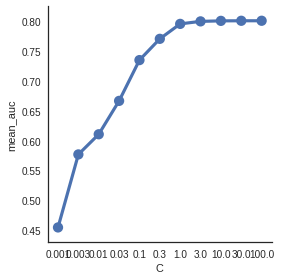

In [33]:
train_GLM1.plot()

In [34]:
# how does the model differ if we use scaled inputs?
train_GLM1_scaled = Train(x = inputTrainScaled.loc[:, fullSet],
                          y = outcomeTrain,
                          method = GLM_L1,
                          metric = AUC,
                          trControl = trControl,)

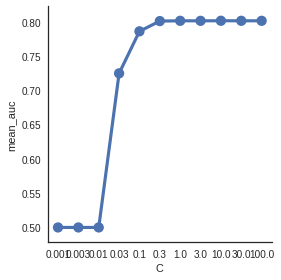

In [35]:
train_GLM1_scaled.plot()

the scaled input doesnt offer any performance gains.

### Nonlinear models

Lets look at K-nearest neighbors and a neural network (sk-learn calls this a multi layer perceptron).

In [36]:
# need to be careful about zero variance predictors with KNN
# in this case there are none!
train_knn = Train(inputTrainScaled.loc[:, fullSet],
                  outcomeTrain,
                  KNN_Cls,
                  metric = AUC,
                  trControl = trControl,
                  tuneGrid = pd.DataFrame({'n_neighbors': np.arange(11, 61, 4)})
                  )

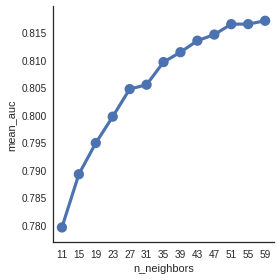

In [37]:
train_knn.plot()

knn performs fairly well, despite simplicity

In [38]:
# single layer nnet
nnet_grid = expand_grid({'hidden_layer_sizes' : [100, 200, 250],
                         'alpha' : [0.01, 0.3, 1.0, 3.0]})

train_nnet = Train(inputTrainScaled.loc[:, reducedSet],
                  outcomeTrain,
                  NNet_Cls,
                  metric = AUC,
                  trControl = trControl,
                  tuneGrid = nnet_grid
                  )

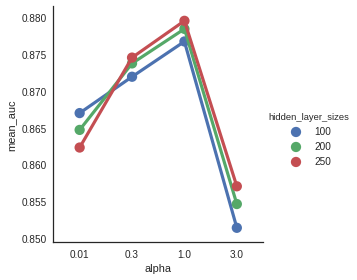

In [39]:
train_nnet.plot()

performance drops off sharply beyond alpha (penalty) > 1. See little difference in performance with extra units in hidden layer, so should prefer the most simple. This is a feature that will be added in future releases: Brieman proposed that the best model should be the simplest that performs within one standard error of the most performant.

### Trees

Lets try:

- random forest
- xgboost

pycaret adds flexibility to easily add learning algorithms from different packages: for example, XGBoost is not found in scikit-learn

In [40]:
# Random Forest
# custom grid to override defaults
grid_cust = expand_grid({'n_estimators' : [100, 250, 500],
                         'max_depth' : [3, 6, 9, 12],
                         'max_features' : [4, 5, 6]})

train_RF = Train(inputTrain.loc[:, fullSet],
               outcomeTrain,
               RF_Cls,
               metric = AUC,
               trControl = trControl,
               tuneGrid = grid_cust)


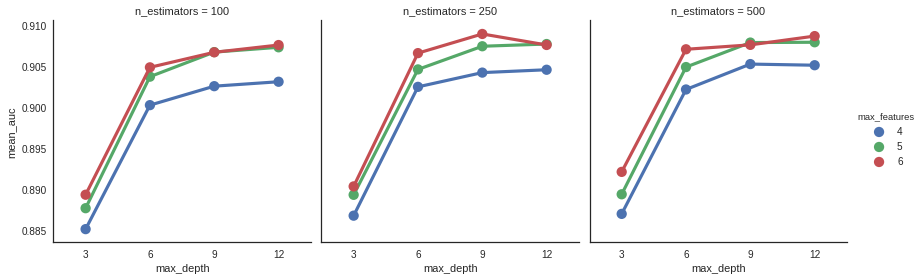

In [41]:
train_RF.plot()

In [42]:
# XGBoost
train_XGB = Train(inputTrain.loc[:, fullSet],
                  outcomeTrain,
                  XGB_Cls,
                  tuneGrid = expand_grid({'n_estimators' : [25, 50, 100],
                                          'learning_rate' : [0.01, 0.03, 0.1, 0.3],
                                          'max_depth' : [3, 6, 9]}),
                  metric = AUC,
                  trControl = trControl,
                      )

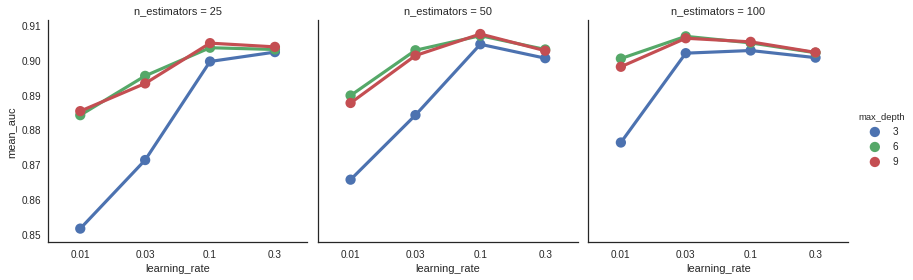

In [43]:
train_XGB.plot()

## Test set evaluation

In [44]:
# evaluate all with some clever mapping, combine in a neat dot plot with train/test performance (AUC)

In [45]:
models = [train_GLM1, train_GLM1_scaled, train_knn, train_nnet, train_RF, train_XGB]
names = ['GLM L1', 'GLM L1 (scaled)', 'KNN', 'NNet', 'RF', 'XGB']
dataset = [0,1,2,3,0,0]
res_array = np.empty([6, 2])

In [47]:
# Train set results
for i, model, n in zip(range(6),models, names):
    res_array[i, 0] =  model.best.loc[:, 'mean_auc'].values[0]
    print('{}, train AUC: {:.4f}'.format(n, model.best.loc[:, 'mean_auc'].values[0]))

GLM L1, train AUC: 0.8014
GLM L1 (scaled), train AUC: 0.8014
KNN, train AUC: 0.8171
NNet, train AUC: 0.8795
RF, train AUC: 0.9090
XGB, train AUC: 0.9076


In [48]:
# Test set- need to be careful as models used different features, and some scaled
for i,  model, n, ds in zip(range(6), models, names, dataset):
    if ds == 0:
        res = model.predict(inputTest.loc[:, fullSet], predict_proba = True)[:,1]
    elif ds == 1:
        res = model.predict(inputTestScaled.loc[:, fullSet], predict_proba = True)[:,1]
    else:
        res = model.predict(inputTestScaled.loc[:, reducedSet], predict_proba = True)[:,1]
    res_auc = AUC()(res, outcomeTest.values)
    res_array[i, 1] = res_auc
    print('{}, test AUC: {:.4f}'.format(n,res_auc))

GLM L1, test AUC: 0.8402
GLM L1 (scaled), test AUC: 0.8400
KNN, test AUC: 0.8566
NNet, test AUC: 0.9132
RF, test AUC: 0.9238
XGB, test AUC: 0.9259


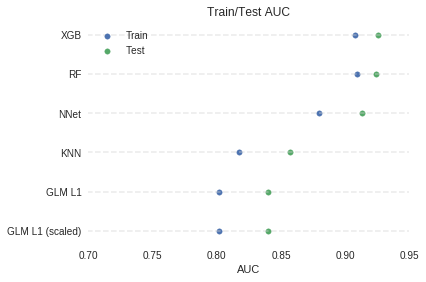

In [116]:
# make a pretty dot plot
res_df = pd.DataFrame(res_array, index = names, columns= ['train', 'test'])
res_df = res_df.sort_values(by = 'test')

train_res = res_df.train.values
test_res = res_df.test.values
N = len(train_res)

ind = np.arange(N)  
width = 0.35      

fig, ax = plt.subplots()

pointsTrain = ax.scatter(train_res, ind, s=30, label = 'Train')
pointsTest = ax.scatter(test_res, ind, s=30, label = 'Test')

for i in ind:
    ax.plot((0,1), (i,i),'--', color="lightgray", alpha=0.4)

ax.set_xlabel('AUC')
ax.set_title('Train/Test AUC')
ax.set_yticks(ind + width / 2)
ax.set_yticklabels(res_df.index.values)
ax.set_xlim([0.7, 0.95])

ax.legend(loc = 'upper left')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([x for x in ind])
plt.tight_layout(True)

plt.show()

## Summary

So there we have it, a simple demonstration of pycaret functionality

## Upcoming developments for pycaret

- parallised training- should bring speed gains
- preprocessing: center, scale, PCA
- more plotting helper functions
- more models
- more examples!